# Cluster-embedding algorithm demo on karate club graph
This notebook demonstrates the cluster-embedding algorithm used in the graph domain to cluster nodes and come up with node embeddings.

The algorithm in high level is
1. Randomly initialize k clusters where k is the desired embedding size of a node
2. For every node, compute its embedding by calculating the cluster affinity with a particular cluster 
> * cluster_affinity(node_i, cluster_j) = sum(node_affinity(node_i, node_j) for every node_j in cluster_j)
> * node_affinity(node_i, node_j) = 1/len(shortest_path(node_i, node_j))

3. Perform k-means clustering of the nodes based on the embeddings just computed
4. Using the newly obtained clusters repeat the process unitl convergence is reached or unitl `max_iter` iterations have been done


The main idea behind this seemingly random algorithm is that if given ideal clusters of nodes, nodes in the same cluster will have very similar affinity with other clusters as these nodes are very close to each other and have the same neighbourhood. 

Hence the nodes in the same cluster will have very similar embeddings and hence k-means algorithm would cluster them together. This shows that ideal clusters would be a point of convergence




## Importing stuff

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
kg = nx.karate_club_graph() # The karate club graph on which the analysis will be done

In [3]:
adjList = dict(kg.adjacency())

## Init Clusters
The first step of the algorithm:


> make `num_clusters` and randomly assign nodes to each cluster 



In [4]:
import random as r
def init_clusters(nodes, num_clusters):
    '''
    Creates num_clusters and assigns the nodes to a cluster
    Returns List(List(node)) 
    '''
    clusters = [[] for _ in range(num_clusters)]
    for node in nodes:
        ind = int(r.random()*num_clusters)
        clusters[ind].append(node)
    
    return clusters


In [5]:
# Sanity check
# Checking if all nodes have been assigned to a cluster
cls = init_clusters(kg.nodes, 5)
from functools import reduce
node_in_clusters = 0
for cluster in cls:
    node_in_clusters += len(cluster)
print(node_in_clusters)
print(len(kg.nodes))

34
34


## Computing cluster affinity of a node

### Computing node-node affinity:
The algorithm implmented here is the inverse of the shortest path b/w the 2 nodes. The nodes are expected to not be the same

In [39]:
kg.name

"Zachary's Karate Club"

In [40]:
# For optimization, the values would be cached
sp_cache = {}

def sp_node_affinity(graph, n1, n2, maxVal = 10**5):
    '''
    Given graph, n1, n2, returns 1/shortest_path(graph, n1, n2)
    '''
    key = (graph.name, n1, n2)
    if key in sp_cache:
        return sp_cache[key]
    try:
        sp_cache[key] = 1/nx.shortest_path_length(graph, n1, n2)
        return sp_cache[key]
    except:
        sp_cache[key] = maxVal
        return maxVal

In [41]:
# Sanity check:
print(sp_node_affinity(kg, 1, 4))

0.5


## Cluster affinity 
Cluster affinity between node_i, cluster_j is
> sum(node_affinity(node_i, node_j) for every node_j in cluster_j )

In [42]:
def cluster_affinity(graph, node, cluster, node_affinity = sp_node_affinity):
    affinity = 0
    for nodej in cluster:
        if nodej != node:
            affinity += node_affinity(graph, node, nodej)
    
    return affinity

In [43]:
# Sanity check
node = 2
for ind, cluster in enumerate(cls):
    print("Affinity of node %d with cluster %d: "%(node, ind), cluster_affinity(kg, node, cluster))

Affinity of node 2 with cluster 0:  1.5
Affinity of node 2 with cluster 1:  2.8333333333333335
Affinity of node 2 with cluster 2:  4.333333333333334
Affinity of node 2 with cluster 3:  7.0
Affinity of node 2 with cluster 4:  5.333333333333334


## Computing node embedding given clusters

In [44]:
def compute_embedding(graph, clusters, node_affinity = sp_node_affinity):
    '''
    Outputs a np array shaped (num_nodes, num_clusters)
    '''
    nodes = graph.nodes
    embedding_matrix = []
    for node in nodes:
        node_embedding = [cluster_affinity(graph, node, cluster, node_affinity) for cluster in clusters]
        embedding_matrix.append(node_embedding)
    
    embedding_matrix = np.array(embedding_matrix)
    return embedding_matrix
        

In [45]:
embs = compute_embedding(kg, cls)
print(embs.shape)
print("First 5 rows: \n", embs[:5])

(34, 5)
First 5 rows: 
 [[2.33333333 4.83333333 5.         5.83333333 5.16666667]
 [1.33333333 3.16666667 3.83333333 4.16666667 6.66666667]
 [1.5        2.83333333 4.33333333 7.         5.33333333]
 [1.83333333 2.66666667 3.33333333 4.16666667 5.66666667]
 [1.75       3.25       2.66666667 3.         4.        ]]


## K - means clustering
Using k-means clustering to create new clusters using embeddings

In [46]:
from sklearn.cluster import KMeans

In [47]:
def get_new_clusters(nodes, embeddings):
    '''
    nodes, embeddings is expected to match row_wise
    Returns a list new clusters: List[List[node]]    
    '''
    n_clusters = embeddings.shape[1]
    
    kmeans = KMeans(n_clusters = n_clusters).fit(embeddings)
    labels = list(kmeans.labels_)
    cluster_dict = {}
    for node, label in zip(nodes, labels):
        if label in cluster_dict:
            cluster_dict[label].append(node)
        else:
            cluster_dict[label] = [node]
    
    clusters = [i[1] for i in cluster_dict.items()]
    return clusters
    
    
    
    

In [48]:
nodes = kg.nodes
embeddings = embs
new_clusters = get_new_clusters(nodes, embeddings)

In [49]:
# Sanity check
print("First cluster", new_clusters[0])
nodes_in_clusters = 0
for cluster in new_clusters:
    nodes_in_clusters += len(cluster)
print("Total nodes in new clusters " ,nodes_in_clusters)


First cluster [0]
Total nodes in new clusters  34


## Putting it all together

In [50]:
def node2vec_via_clustering(graph, vec_size, num_iter = 200, node_affinity = sp_node_affinity):
    '''
    Output:
        Cluster as List[List[node]]
        embedding matrix with ind2node mapping done by graph.nodes
    '''
    
    num_clusters = vec_size
    clusters = init_clusters(graph.nodes, num_clusters) # Initialize the clusters
    
    for iteration in range(num_iter):
        embeddings = compute_embedding(graph, clusters, node_affinity) # Computing node embeddings from given clusters
        clusters = get_new_clusters(graph.nodes, embeddings) # Performing k-means clustering based on node embeddings and returning new clusters
    
    return clusters, embeddings

In [51]:
clusters, embeddings = node2vec_via_clustering(kg, 5, num_iter = 500)

In [52]:
clusters

[[0],
 [1, 3, 4, 5, 6, 7, 10, 11, 12, 16, 17, 21],
 [2, 8, 13, 19, 30, 31],
 [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29],
 [32, 33]]

### Labelling nodes based on clusters assigned to them

In [53]:
def label_nodes(nodes, clusters):
    labels = []
    for node in nodes:
        for ind, cls in enumerate(clusters):
            if node in cls:
                labels.append(ind)
                break
    
    return labels


In [54]:
# Sanity check
labels = label_nodes(kg.nodes, clusters)
print(len(labels))

34


## Ploting the graph with labels

### Plotting node embeddings using PCA

In [55]:
from sklearn.decomposition import PCA

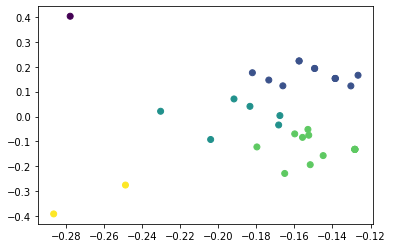

In [56]:
pca = PCA(n_components = 2)
pca.fit(embeddings.T)
x = pca.components_[0]
y = pca.components_[1]
labels = label_nodes(kg.nodes, clusters)
plt.scatter(x, y, c = labels)

### Plotting the graph with nodes color based on clusters

In [57]:
import random
import matplotlib.patches as mpatches


def assign_labels(graph, labels):
    for i,node in enumerate(graph.nodes()):
        graph.nodes[node]['label'] = labels[i]

def plot_graph(graph, n_clusters, labels ,title='Graph after Clustering'):
    # Plots the graph     
    assign_labels(graph, labels)

    colour_list = ['blue','green','red','yellow','cyan', 'magenta','lightblue','grey']
    sampled_colours = dict(zip(set(labels),random.sample(colour_list, n_clusters)))

    legend_handles = []
    for label, color in sampled_colours.items():
        colour_handle = mpatches.Patch(color=color, label=label)
        legend_handles.append(colour_handle)

    colours = [sampled_colours[i] for i in labels]

    pos_fr = nx.fruchterman_reingold_layout(graph)
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.legend(handles=legend_handles)
    nx.draw(graph, pos=pos_fr, node_size=500, node_color=colours, with_labels=True)
    plt.show()

### Plotting graph with cluster_embedding algorithm

In [61]:
k = 7
clusters, embeddings = node2vec_via_clustering(kg, k, num_iter = 500)
labels = label_nodes(kg.nodes, clusters)

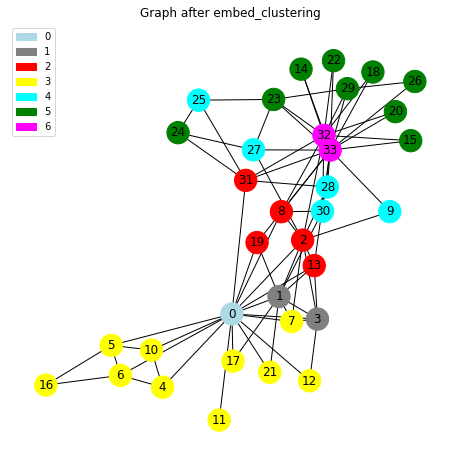

In [62]:
plot_graph(kg, k, labels, 'Graph after embed_clustering')

### Clustering using spectral clustering

In [65]:
# This is for performing spectral clustering
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 
import matplotlib.patches as mpatches
import random
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from itertools import count 



# Class to perform spectral clustering for k clusters, given k

class SpectralClustering:
    
    def __init__(self, G):
        # Initialize the graph, nodes and the normalized Laplacian

        self.graph = G
        self.normalized_laplacian = nx.linalg.normalized_laplacian_matrix(G).toarray()
        self.nodes = G.nodes()

    def compute_eigenspace(self):
        # Compute the eigenvalues and the eigenvectors using Numpy and sort them in ascending order 

        eigenvalues, eigenvectors = np.linalg.eig(self.normalized_laplacian)

        sort_index = np.argsort(eigenvalues) # Returns the list of indices that would sort the array
        sorted_eigenvectors = eigenvectors[:, sort_index]

        return sorted_eigenvectors

    def fit(self, k):
        """
        Step 1: Extract the k eigen vectors and stack them vertically to form a matrix (i.e each vector is a column)
        Step 2: Every row of this matrix represents the features of the respective nodes of the graph
        Step 3: Perform K-Means clustering on this dataset to identify k clusters

        """
        eigenvectors = self.compute_eigenspace()
        k_eigenvectors = np.array(eigenvectors)[:,:k]
        dataset = pd.DataFrame(k_eigenvectors, index=self.nodes)

        # print(dataset)

        k_means_clusters = KMeans(n_clusters = k, random_state=42)
        self.clusters = k_means_clusters.fit(k_eigenvectors)
        
    def predict_labels(self):
        # Returns the labels 
        return self.clusters.labels_

    def assign_labels(self, labels):
        # Helper to assign the labels as node attributes
        for i,node in enumerate(self.graph.nodes()):
            self.graph.nodes[node]['label'] = labels[i]

    def plot_graph(self, n_clusters, title='Graph after Spectral Clustering'):
        # Plots the graph 

        labels = self.clusters.labels_
        self.assign_labels(labels)

        colour_list = ['blue','green','red','yellow','cyan', 'magenta','lightblue','grey']
        sampled_colours = dict(zip(set(labels),random.sample(colour_list, n_clusters)))

        legend_handles = []
        for label, color in sampled_colours.items():
            colour_handle = mpatches.Patch(color=color, label=label)
            legend_handles.append(colour_handle)

        colours = [sampled_colours[i] for i in labels]

        pos_fr = nx.fruchterman_reingold_layout(self.graph)
        plt.figure(figsize=(8,8))
        plt.title(title)
        plt.legend(handles=legend_handles)
        nx.draw(self.graph, pos=pos_fr, node_size=500, node_color=colours, with_labels=True)
        plt.show()

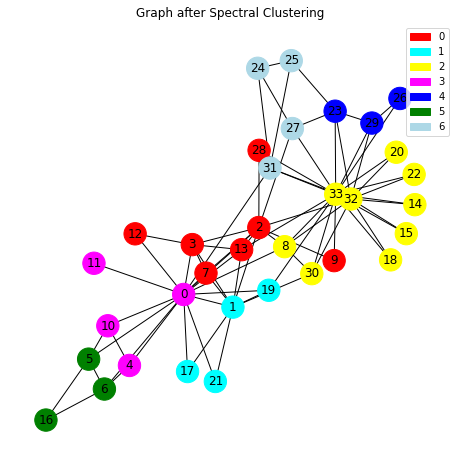

In [66]:
specClust = SpectralClustering(kg)
specClust.fit(k)

specClust.plot_graph(k)